[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1nC3zMTRjp5UztroJXmz7ILcctviRdVJy)
# Deep Learning Homework - Group Zerocool

## Team Members
- **Néder Brúnó** (Neptun Code: NQKZUX)
- **Jenei Ákos** (Neptun Code: EBBUE7)
- **Tasi Gergő** (Neptun Code: BRY27P)


## Project Overview
Our project aims to create a **Convolutional Neural Network (CNN)** that can identify skin cancer in patients using images of affected areas. We will utilize the **ISIC 2024 Challenge** dataset, provided by Kaggle, which contains a wide range of dermoscopic images for skin cancer diagnosis.

For more information about the dataset, you can visit the competition page on Kaggle: [ISIC 2024 Challenge](https://www.kaggle.com/competitions/isic-2024-challenge).

---

### For the first milestone of this project, we will be:

- Downloading and importing the database.

- Removing the incomplete or unneccessary parts of the metadata provided.

- Shrinking the database, due to the small amount of positive cases compared to the negative ones.

- Loading in the images from the disk.

- Splitting the metadata and the images into Train, Validation and Test sets.

---

### For the second milestone of this project, we will be:

- Improving the way data is handled.

- Creating the base models for the project.

- Running and testing the models.

- Balancing the Positive to Negative data ratio.



In [14]:
#install all the required packages
%pip install numpy matplotlib opencv-python rarfile tensorflow pandas scikit-learn requests patool seaborn


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: C:\Users\neder\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [30]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
import cv2
import matplotlib.pyplot as plt
import os
import zipfile
import requests
tf.get_logger().setLevel('ERROR')

### Below are variables to easily control the models and other data in the Notebook.

In [16]:
folder_path = "data/train-image/image"      #Folder where the training images are stored
sheet_path = "data/train-metadata.csv"      #Folder where the training sheet is stored
download_data = False                       #True/False depending on whether you wish to download the dataset or not

images_to_load = 3000                       #Amount of non cancerous images to load along with all the 393 cancerous pictures
duplicate_cancerous_imgs = True             #True/False depending on wheter you wish to augment and duplicate the cancerous images 
duplicate_non_cancerous_imgs = False        #True/False depending on wheter you wish to augment and duplicate the non cancerous images 
duplicate_imgs_number = 7                   #Amount of duplicate images to create


duplicate_cancerous_metadata = True         #True/False depending on wheter you wish to augment and duplicate the cancerous metadata rows
duplicate_non_cancerous_metadata = False    #True/False depending on wheter you wish to augment and duplicate the non cancerous metadata rows 
duplicate_metadata_number =  7            #Amount of duplicate rows to create
augment_variation = 0.1                     #Range of data multiplication (Ex. if 0.1 then it multiplies all data by a random number between 0.9 and 1.1)

epochs = 15                                 #Number of epochs to run the model for
steps_per_epoch = 32

In [17]:
#Downloading the database next to the notebook (credits to Kaggle: https://www.kaggle.com/competitions/isic-2024-challenge)
if download_data:
    response = requests.get("https://dl.dropboxusercontent.com/scl/fi/druub1bxwxl5wjkwndg8c/data.zip?rlkey=bcveewvfp9hvpkz99z04n97et&st=dpqdbvl2&dl=0")
    with open('data.zip', 'wb') as file:
        file.write(response.content)

In [18]:
#Unzip the downloaded data into a folder next to the notebook
if download_data:
    with zipfile.ZipFile('data.zip', 'r') as zip_ref:
        zip_ref.extractall()

---

### We have made some changes to the database's metadata outside of the code:

- We removed collumns which's data we deemed unneccessary or that which would've ruined the learning capability of the model.

- In the age collumn there was incomplete data. We replaced the empty spaces with the average age of the patients. (58)

- Changed the raw text type of the photo's location to a one-hot-coded style, with 8 new collumns.


In [19]:
#Read in the entire raw database using panda
X_metadata = pd.read_csv(sheet_path)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Separate the cancerous and non cancerous photos, so we can prune the data,
#as 400k+ negative and 393 positive cases is not a good ratio to teach the model with.
X_metadata_cancer =  X_metadata[X_metadata["target"] != 0]
X_metadata_notcancer = X_metadata[X_metadata["target"] != 1]

#Select the first 'images_to_load' elements in the not cancerous pictures
#This number can be changed in the import section to fine-tune learning.
X_metadata = X_metadata_notcancer[:images_to_load]

#And then merge it together with the 393 cancerous pictures
X_metadata = pd.concat([X_metadata, X_metadata_cancer])

print(X_metadata.shape)

#Split off the ID and Target section to a different dataframe (Y)
features = ["isic_id", "target"]
Y_metadata = X_metadata.filter(features)

#Split off only the target field of the database (Y)
Y_target = X_metadata.filter(['target'])

metadata = X_metadata

#Delete the target collumn from the X dataframe
X_metadata = X_metadata.drop(columns=["target"])

(3393, 45)


In [20]:
#We use Min-Max scaling to increase the learning accuracy of the model

#Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

#Select only the numerical columns to scale
numerical_cols = X_metadata.select_dtypes(include=['float64', 'int64']).columns

#Scale the numerical columns using apply
X_metadata[numerical_cols] = X_metadata[numerical_cols].apply(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())
print(X_metadata[:4])

        isic_id  age_approx  clin_size_long_diam_mm  tbp_lv_A  tbp_lv_Aext  \
0  ISIC_0015670    0.642857                0.094463  0.379483     0.448177   
1  ISIC_0015845    0.642857                0.004188  0.664434     0.704390   
2  ISIC_0015864    0.642857                0.111215  0.437412     0.472557   
3  ISIC_0015902    0.714286                0.102839  0.230348     0.332853   

   tbp_lv_B  tbp_lv_Bext  tbp_lv_C  tbp_lv_Cext  tbp_lv_H  tbp_lv_Hext  \
0  0.517613     0.375848  0.514322     0.439011  0.730394     0.415154   
1  0.504884     0.393312  0.663542     0.604710  0.517795     0.204435   
2  0.755377     0.655815  0.722084     0.665091  0.829204     0.541977   
3  0.399800     0.292614  0.357099     0.319450  0.783814     0.490943   

   tbp_lv_L  tbp_lv_Lext  tbp_lv_areaMM2  tbp_lv_area_perim_ratio  \
0  0.709664     0.641798        0.016307                 0.421858   
1  0.628616     0.545214        0.001717                 0.028418   
2  0.703684     0.636650       

### Augmenting and Duplicating the metadata rows

In [21]:
#We will use 20% of the data to Validate the model and 20% to Test the model.

#Split main dataset into train and test batches.
X_train, X_test, Y_train, Y_test = train_test_split(metadata, Y_metadata, test_size=0.2, shuffle=True, random_state=2)

#Split training dataset into train and validation batches
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2/0.8, random_state=3)# 0.2/0.8 x 0.8 = 0.2

print("X shape:")
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(" ")
print("Y shape:")
print(Y_train.shape)
print(Y_test.shape)
print(Y_val.shape)
print(" ")
print("first element:")
print(" ")
print(X_train.iloc[0])
print(" ")
print(Y_train.iloc[0])

X shape:
(2035, 45)
(679, 45)
(679, 45)
 
Y shape:
(2035, 2)
(679, 2)
(679, 2)
 
first element:
 
isic_id                         ISIC_0135176
target                                     0
age_approx                                70
clin_size_long_diam_mm                  4.52
tbp_lv_A                           12.161482
tbp_lv_Aext                          12.6715
tbp_lv_B                           13.685301
tbp_lv_Bext                        15.783193
tbp_lv_C                            18.30817
tbp_lv_Cext                        20.240457
tbp_lv_H                           48.374014
tbp_lv_Hext                        51.240841
tbp_lv_L                           17.907394
tbp_lv_Lext                        22.113243
tbp_lv_areaMM2                     12.047288
tbp_lv_area_perim_ratio            18.959197
tbp_lv_color_std_mean                0.81603
tbp_lv_deltaA                      -0.510018
tbp_lv_deltaB                      -2.097892
tbp_lv_deltaL                      -4.205849
tb

In [43]:
# Function to augment metadata
# Applies scaling to non-excluded columns

def augment_metadata(row, exclude_columns, augment_variation):
    new_row = row.copy()
    for col in row.index:
        if col not in exclude_columns:
            new_row[col] = row[col] * np.random.uniform(1.0 - augment_variation, 1.0 + augment_variation)
    return new_row


# Function to add a tiny bit of noise to the augmented images
# Useful so we can duplicate more images without the model learning the exact images
def add_noise(img):
    noise = np.random.normal(loc=0.0, scale=0.01, size=img.shape)
    img_noisy = img + noise
    img_noisy = np.clip(img_noisy, 0.0, 1.0)  # Ensure pixel values are valid
    return img_noisy


# Augmentation function that applies transformations and yields multiple augmented images

def augment_image(image, num_augmented_versions=1):
    data_gen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        preprocessing_function=add_noise  # Apply the noise function
    )

    # Expand dimensions to match the expected input shape
    image = np.expand_dims(image, axis=0)

    # Generate augmented images
    for _ in range(num_augmented_versions):
        augmented_image = next(data_gen.flow(image, batch_size=1))[0]
        yield augmented_image


# Function to load and preprocess images with the given name
def preprocess_image(image_name):
    image_path = os.path.join(folder_path, image_name + ".jpg")

    img = cv2.imread(image_path)

    if img is None:
        raise FileNotFoundError(f"Image {image_name} not found in folder.")

    # Resize all images to 125x125
    img = cv2.resize(img, (125, 125))

    # Normalize the images to improve model's learning accuracy
    img = img / 255.0
    img = img.astype(np.float32)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


# Image loading function with generation of multiple augmented images and metadata

def data_generator(Y_metadata, duplicate_metadata_number, augment_variation, exclude_columns):
    for idx, row in Y_metadata.iterrows():
        image_name = row['isic_id']
        try:
            # Load and resize the image
            img = preprocess_image(image_name)

            # Yield the original image and metadata
            #print(row)
            yield img, row.drop(['isic_id','target']).values, row['target']

            # If augmentation is enabled, generate and yield augmented versions of both metadata and images
            if (row['target'] == 1 and duplicate_cancerous_imgs) or (duplicate_non_cancerous_imgs and row['target'] == 0):
                for _ in range(duplicate_metadata_number):
                    # Augment metadata
                    augmented_metadata = augment_metadata(row, exclude_columns, augment_variation)

                    # Augment image and yield augmented image and metadata
                    for augmented_img in augment_image(img):
                        yield augmented_img, augmented_metadata.drop(['isic_id','target']).values, augmented_metadata['target']

        except FileNotFoundError:
            print(f"Image {image_name} not found in folder.")


# Create the image datasets for train-validation-test sets with TensorFlow Dataset generator

def create_dataset(metadata):
    return tf.data.Dataset.from_generator(
        lambda: data_generator(metadata, duplicate_metadata_number, augment_variation, exclude_columns),
        output_signature=(
            tf.TensorSpec(shape=(125, 125, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(len(metadata.columns) - 2,), dtype=tf.float32),  # Metadata features (excluding 'isic_id')
            tf.TensorSpec(shape=(), dtype=tf.float32),  # Target label
        )
    )


# Define exclude columns for metadata augmentation
exclude_columns = [
    'isic_id', 'target', 'head_neck', 'torso_front',
    'torso_back', 'right_leg', 'right_arm',
    'left_leg', 'left_arm', 'unknown'
]

# Create the train, validation, and test sets with augmentation, in batches of 32
train_data = create_dataset(X_train).shuffle(10000).batch(32)
validation_data = create_dataset(X_val).shuffle(10000).batch(32)
test_data = create_dataset(X_test).shuffle(10000).batch(32)

In [23]:
for x,y,z in train_data:
    print(x,y,z)
    break

tf.Tensor(
[[[[0.73497593 0.6207699  0.5556869 ]
   [0.75121814 0.6363252  0.55560756]
   [0.757223   0.6341782  0.5643257 ]
   ...
   [0.6847013  0.58687925 0.47819507]
   [0.6880152  0.5970362  0.50102997]
   [0.70374334 0.5682457  0.5033871 ]]

  [[0.7303366  0.60129637 0.5485791 ]
   [0.73943424 0.6232088  0.5377071 ]
   [0.74126077 0.61398965 0.55211794]
   ...
   [0.7229899  0.5945518  0.50051343]
   [0.6985221  0.58829725 0.50378454]
   [0.7119831  0.59144044 0.51815695]]

  [[0.7188972  0.5956112  0.5422218 ]
   [0.73214185 0.59608346 0.5189338 ]
   [0.7188318  0.59239626 0.5201592 ]
   ...
   [0.7579125  0.6448775  0.5556652 ]
   [0.7373854  0.62673956 0.53653735]
   [0.74750364 0.62255615 0.51696575]]

  ...

  [[0.79048836 0.6558351  0.56053644]
   [0.77477735 0.6417581  0.54818743]
   [0.7670626  0.65321755 0.55071735]
   ...
   [0.7227563  0.5392893  0.5325041 ]
   [0.71318114 0.5633367  0.49013895]
   [0.708974   0.5431996  0.49614483]]

  [[0.74984884 0.65277237 0.558986

In [24]:
#num_train_images_positive = sum(1 for image, data, label in train_data.unbatch() if label == 1)
#num_train_images_negative = sum(1 for image, data, label in train_data.unbatch() if label == 0)
#print("Amount of non cancerous images in training pile:", num_train_images_negative)
#print("Amount of cancerous images in training pile:", num_train_images_positive)

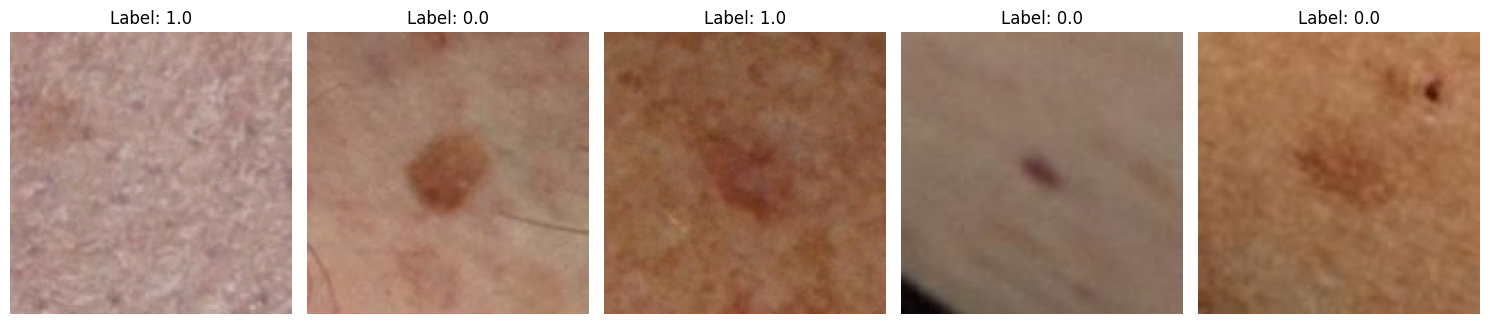

In [39]:

def display_random_images(dataset, num_images=5):
    #Extract a batch of images and labels
    images, data, labels = next(iter(dataset.shuffle(buffer_size=10000).take(1)))
    
    #Select random indices
    random_indices = np.random.choice(images.shape[0], num_images, replace=False)
    
    #Plot the images
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(random_indices):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[idx])
        plt.title(f"Label: {labels[idx].numpy()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

#Display some random images from the training set
display_random_images(train_data)

---
### CNN Model for Binary Classification

- **Architecture:** `Conv2D` → `MaxPooling2D` → `Conv2D` → `MaxPooling2D` → `Flatten` → `Dense` → `Output`
- **Layers:**
  - 2 `Conv2D`: 32 filters, 3x3 kernel, ReLU
  - 2 `MaxPooling2D`: 2x2 pool
  - 1 `Dense`: 64 units, ReLU
  - 1 `Output`: 1 unit, sigmoid for binary classification
- **Compilation:** Adam optimizer, binary cross-entropy loss, val_accuracy metric
- **Callbacks:** EarlyStopping on `accuracy`, ModelCheckpoint for best model


---
### Dense Neural Network for Binary Classification

- **Architecture:** `Dense` → `Dense` → `Dense` → `Output`
- **Layers:**
  - 3 `Dense`: 256 units, ReLU
  - 1 `Output`: 1 unit, sigmoid for binary classification
- **Compilation:** Adam optimizer, binary cross-entropy loss, accuracy metric
- **Callbacks:** EarlyStopping on `val_accuracy`, ModelCheckpoint for best model




In [44]:
# Define the first model (CNN)
model1 = Sequential([
    Conv2D(32, (3, 3), strides=(1, 1), padding="valid", activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid")
])

# Define the second model (Dense network)
model2 = Sequential()
model2.add(Dense(units=256, activation='relu'))
model2.add(Dense(units=256, activation='relu'))
model2.add(Dense(units=256, activation='relu'))
model2.add(Dense(units=1, activation='sigmoid'))

# Define the first model (CNN)
cnn_input = Input(shape=(125, 125, 3))
cnn_output = model1(cnn_input)

# Define input for additional features
additional_input = Input(shape=(len(X_train.columns) - 2,))

# Concatenate the CNN output with the additional features
combined = Concatenate()([cnn_output, additional_input])

# Pass the concatenated input through the Dense layers of the second model
dense_output = model2(combined)

# Create the final model
combined_model = Model(inputs=[cnn_input, additional_input], outputs=dense_output)

# Compile the combined model
combined_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
callbacks_combined = [
    EarlyStopping(monitor='val_accuracy', patience=3),
    ModelCheckpoint('combined_model.keras', save_best_only=True)
]

# Train the combined model
history_combined = combined_model.fit(
    train_data.map(lambda img, metadata, target: ((img, metadata), target)),
    epochs=epochs,
    validation_data=validation_data.map(lambda img, metadata, target: ((img, metadata), target)),
    verbose=1,
    callbacks=callbacks_combined
)

Epoch 1/15
    116/Unknown 15s 70ms/step - accuracy: 0.5936 - loss: 7.6635

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


116/116 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.5941 - loss: 7.6231 - val_accuracy: 0.7226 - val_loss: 0.6922
Epoch 2/15


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


115/116 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7145 - loss: 0.8731

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.7148 - loss: 0.8714 - val_accuracy: 0.6777 - val_loss: 0.9353
Epoch 3/15


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


115/116 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7453 - loss: 0.6990

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


116/116 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - accuracy: 0.7453 - loss: 0.6986 - val_accuracy: 0.7492 - val_loss: 0.5759
Epoch 4/15


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


115/116 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7877 - loss: 0.4983

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.7875 - loss: 0.4989 - val_accuracy: 0.7841 - val_loss: 0.6195
Epoch 5/15


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


115/116 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8124 - loss: 0.4428

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.8125 - loss: 0.4425 - val_accuracy: 0.7309 - val_loss: 0.7850
Epoch 6/15


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


115/116 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7722 - loss: 0.5427

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.7723 - loss: 0.5427 - val_accuracy: 0.8181 - val_loss: 0.4406
Epoch 7/15


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


115/116 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8008 - loss: 0.4158

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.8007 - loss: 0.4161 - val_accuracy: 0.6985 - val_loss: 0.6428
Epoch 8/15


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


115/116 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7662 - loss: 0.5085

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - accuracy: 0.7668 - loss: 0.5073 - val_accuracy: 0.7608 - val_loss: 0.5723
Epoch 9/15


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8196 - loss: 0.3877

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


116/116 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - accuracy: 0.8197 - loss: 0.3877 - val_accuracy: 0.7749 - val_loss: 0.6128


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

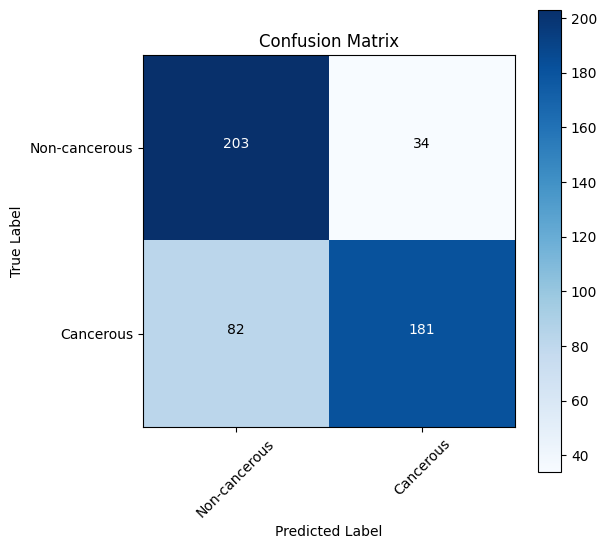

In [45]:
def plot_confusion_matrix(model, dataset):
    y_true = []
    y_pred = []
    for img, metadata, target in dataset:
        prediction = model.predict([np.expand_dims(img, axis=0), np.expand_dims(metadata, axis=0)])
        y_true.append(target.numpy())
        y_pred.append(1 if prediction >= 0.5 else 0)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Non-cancerous', 'Cancerous'], rotation=45)
    plt.yticks(tick_marks, ['Non-cancerous', 'Cancerous'])

    # Display the numbers on the confusion matrix
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Example usage of confusion matrix
plot_confusion_matrix(combined_model, test_data.unbatch().take(500))